# Image Autoencoders experiments

In [1]:
import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils
from torchvision import datasets
from torchvision.utils import save_image
import skimage 

In [2]:
import io
import requests
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os

%matplotlib inline

Some code comes from github [SherlockLiao](https://github.com/SherlockLiao/pytorch-beginner/tree/master/08-AutoEncoder)

## Foveal and scaled Images Autoencoders

### Experiment Description

This experiment has as a goal to train small autoencoders where the encoding (and decoding) parts will be lately used to create a more complex foveal based variational and autoencoder system

The output vector from each of these small encoders *DOES NOT* meant to be a compressed (or decompressed) from the image, but means to be a vector that can be used to make later operations possible.

On the contrary, I take an assumption leap in the knowledge and intelligence structure that the following holds:
The first stages of encoding actually spread the code to a known vector dimension. This vector dimension (might) be bigger than the input domain, but with a more distributted and sparse encoding.

This is the reason why the **fovea** is important, to maintain the vector dimension restrained and constant even with bigger images.

Later stages and higher layers in the minibrain will instead do operations with these and vectors from other sensors to obtain a same-size vector, mainaining (or compressing) the space size but obtaining more complex embeddings that represent higher-level concepts and contexts.

This means if is a dense vector it might (or might not) be small, if it is a sparse vector it might be of a similar to bigger dimensionality than the input patch, the point here is to make it possible to create from an image a more semantically interesting vector for semantic and syntactic operations later (See Vector Symbolic Architectures and Neural Engineering Framework for more ideas on this).

Each resolution layer is dedicated to different tasks, that is why also the fovea contains most of the logic, while other scales are getting less and less dedicated logic. This applies specially the full image one, are simpler, they are used for locating important future focus points. 

### Detailed Description

Different scale Autoencoders are ment to be working on the same image but downsampled differently

The experiment will attack the following scales:

 1. Full Resolution
 2. Downscale 1
 3. Downscale 2
 4. Downscale 3
 5. Full Image Downscaled

 * The _full resolution_ patch will have 10x10 pixels
 * Each _Downscale_ will be the previous scale with a 3x3 gaussial filter with step 2 (this means, half the previous resolution)
 * Each _Downscale_ patch will also be about 10x10 pixels with a maximum of 15x15
 * The _full image_ downscaled will be no less than 50x50 pixels, the downscaling will  be done with torchvision.transforms.Resize(50)
 * Each Downscale will have it's own trained autoencoder
 * the trainig will be done in RGB
 * the images will be obtained from different sources. See Images sources below
 * the training images will be cropped such as to train the filters on the cropped part only
 * for the training, RandomCrop will be used
 * the encoded vector will consist of the output of the convolutional  filters concatenated with some image statistics on each color layer

## Image sources

 * [Deeplearning.net Datasets](http://deeplearning.net/datasets/)
 * [Openimages Dataset](https://github.com/openimages/dataset)
 * [Deeplearning4j Datasets](https://deeplearning4j.org/opendata)
 * [fast.ai datasets wiki](http://wiki.fast.ai/index.php/Image_Datasets)
 * [Wikipedia List of Datasets for ML Research](https://en.wikipedia.org/wiki/List_of_datasets_for_machine_learning_research)
 * [Computer Vision ONLINE](https://computervisiononline.com/)
 * [Montreal Neurological Institute - MNI BITE](http://www.bic.mni.mcgill.ca/~laurence/data/)

## Bibliography, source code and other resources for this experiment on Autoencoders

- [VAE Pytorch commented and annotated](https://vxlabs.com/2017/12/08/variational-autoencoder-in-pytorch-commented-and-annotated/)
- [Adversarial Variational Bayes](https://arxiv.org/abs/1701.04722)
- [Adversarial Autoencoders](https://arxiv.org/abs/1511.05644)
- [Denoising Criterion for Variational Auto-Encoding Framework](https://arxiv.org/abs/1511.06406)
- [Generative Models](https://github.com/wiseodd/generative-models)
- [Another tutorial](https://wiseodd.github.io/techblog/2017/01/24/vae-pytorch/)
- [Tutorial on Variational Autoencoders](https://arxiv.org/abs/1606.05908)
- [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)
- [Pytorch Examples - VAE](https://github.com/pytorch/examples/blob/master/vae/main.py)
- [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)
- [Variational Autoencoders Explained](https://arxiv.org/abs/1312.6114)
- [VAE tutorial](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/variational_auto_encoder)
- [github 1](https://github.com/ethanluoyc/pytorch-vae)
- [github 2](https://github.com/SherlockLiao/pytorch-beginner/blob/master/08-AutoEncoder/Variational_autoencoder.py)
- [github 3](https://github.com/SherlockLiao/pytorch-beginner/blob/master/08-AutoEncoder/conv_autoencoder.py)
- [github 4](https://github.com/ethanluoyc/pytorch-vae/blob/master/vae.py)
- []()
- []()


In [3]:
#definitions of the operations for the full image autoencoder
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406], # from example here https://github.com/pytorch/examples/blob/409a7262dcfa7906a92aeac25ee7d413baa88b67/imagenet/main.py#L94-L95
   std=[0.229, 0.224, 0.225]
#   mean=[0.5, 0.5, 0.5], # from example here http://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
#    std=[0.5, 0.5, 0.5]
)
#test one:
preprocess = transforms.Compose([
    transforms.Resize(50),
    transforms.ToTensor()
])

#the whole image gets resized to a small image that can be quickly analyzed to get important points
def fullimage_preprocess(w=50,h=50):
    return transforms.Compose([
        transforms.Resize((w,h)), #this should be used ONLY if the image is bigger than this size
        transforms.ToTensor(),
        normalize
    ])

#the full resolution fovea just is a small 10x10 patch 
full_resolution_crop = transforms.Compose([
    transforms.RandomCrop(10),
    transforms.ToTensor(),
    normalize
])

def downsampleTensor(crop_size, final_size=15):
    sample = transforms.Compose([
        transforms.RandomCrop(crop_size),
        transforms.Resize(final_size), 
        transforms.ToTensor(),
        normalize
    ])
    return sample
    
#the first downsampled filter will have 3 times the spanned range of the fovea, 
# but will be downsampled to half the definition
downsample_1_crop = downsampleTensor(30)
#the second downsampled filter will have 6 times the spanned range of the fovea,
# but will be downsampled to half of the previous downsampled the definition (or 1/4 resolution of the fovea)
downsample_2_crop = downsampleTensor(60)
#the first downsampled filter will have 12 times the spanned range of the fovea,
# but will be downsampled to half of the previous downsampled the definition (or 1/8 resolution of the fovea)
downsample_3_crop = downsampleTensor(120)

In [4]:
# These classes are mostly taken and modified from the official examples here:
# https://github.com/pytorch/examples/blob/master/vae/main.py 
# and another here: https://github.com/ethanluoyc/pytorch-vae/blob/master/vae.py

class VAEEncoder(nn.Module):
    """
    The Encoder = Q(z|X) for the Network
    As a Variational AutoEncoder with internal linear units
    """
    def __init__(self, in_dim, hid_dim, out_dim):
        super(VAEEncoder, self).__init__()
        #hid_dim = out_dim*20
        #in_dim = w * h * channels
        self.fc1 = nn.Linear(in_dim, hid_dim)
        self.fc21 = nn.Linear(hid_dim, out_dim)
        self.fc22 = nn.Linear(hid_dim, out_dim)
        self.relu = nn.ReLU()
    
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu    
    
    def forward(self, x):
        h1 = self.relu(self.fc1(x))
        mu, logvar = self.fc21(h1), self.fc22(h1)
        return self.reparameterize(mu, logvar), mu, logvar


class VAEDecoder(torch.nn.Module):
    """
    The Decoder = P(X|z) for the Network
    As a Variational AutoEncoder with internal linear units
    """
    def __init__(self, in_dim, hid_dim, out_dim):
        super(VAEDecoder, self).__init__()
        self.linear1 = torch.nn.Linear(in_dim, hid_dim)
        self.linear2 = torch.nn.Linear(hid_dim, out_dim)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.sigmoid(self.linear2(x))

    
class VAE(nn.Module):
    def __init__(self, width, height, channels, h_dim=400, code_dim=100):
        super(VAE, self).__init__()
        self.width = width
        self.height = height
        self.channels = channels
        self.img_dim = width*height*channels
        self.encoder = VAEEncoder(self.img_dim, h_dim, code_dim)
        self.decoder = VAEDecoder(code_dim, h_dim, self.img_dim)
    
    def forward(self, x):
        z, mu, logvar = self.encoder(x.view(-1, self.img_dim))
        return self.decoder(z), mu, logvar
        
    def save_model(self, name, path):
        torch.save(self.encoder, os.path.join(path, "vae_encoder_"+name+".pth"))
        torch.save(self.decoder, os.path.join(path, "vae_decoder_"+name+".pth"))

In [5]:
def get_loaders(batch_size, transformation, dataset = datasets.CIFAR100, cuda=True):

    kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
    train_loader = torch.utils.data.DataLoader(
        dataset('../data', train=True, download=True,
                       transform=transformation),
        batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        dataset('../data', train=False, transform=transformation),
        batch_size=batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader


In [6]:

def train(model, optimizer, loss_function, train_loader, epoch, batch_size, width, height, channels, log_interval=100, cuda=True):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if cuda:
            data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar, width, height, channels)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [7]:
def test(name, model, test_loader, epoch, batch_size, width, height, channels, cuda=True):
    model.eval()
    test_loss = 0
    for i, (data, _) in enumerate(test_loader):
        data = Variable(data, volatile=True)
        if cuda:
            data = data.cuda()
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar, width, height, channels).data[0]
        if i == 0:
            n = min(data.size(0), 100)
            comparison = torch.cat([data[:n],
                                  recon_batch.view(batch_size, channels, width, height)[:n]])
            save_image(comparison.data.cpu(),'vae_results/' + name + '_reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [8]:
def train_save_model(name, model, optimizer, loss_function, transformation, width, height, channels, epochs=10, batch_size=128, dataset = datasets.CIFAR100, cuda=True):
    

    train_loader, test_loader = get_loaders(batch_size, transformation)

    for epoch in range(1, epochs + 1):
        train(model, optimizer, loss_function, train_loader,epoch, batch_size, width, height, channels)
        test(name, model, test_loader,epoch, batch_size, width, height, channels)

    #torch.save(model, name+".pth")
    model.save_model(name, "VAE")

In [9]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar, width, height, channels):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, width*height*channels), size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [10]:
#numbers are chosen so the image size allows for at least 2 convolution layers in a CNN (they'll be used for other parts)
models = [
          ("fovea_12x12", VAE(12,12,3,500,100),full_resolution_crop),
          ("downsample1_16x16-30x30", VAE(16,16,3,500,100), downsampleTensor(30,16)),
          # commented due to image size, it seems that some images fail the training, I'll need to find a good dataset
          # ("downsample2_16x16-60x60", VAE(16,16,3,500,100), downsampleTensor(60,16)),
          # ("downsample3_16x16-120x120", VAE(16,16,3,500,100), downsampleTensor(120,16)),
          # ("downsample4_20x20-240x240", VAE(20,20,3,500,100), downsampleTensor(240,20)),
          # ("downsample5_20x20-480x480", VAE(20,20,3,500,100), downsampleTensor(480,20)),
          ("fullimage_20", VAE(20,20,3,500,100), fullimage_preprocess(20,20)),
          ("fullimage_48", VAE(48,48,3,500,100), fullimage_preprocess(48,48)),
          ("fullimage_72", VAE(72,72,3,500,100), fullimage_preprocess(72,72)),
          ("fullimage_100", VAE(96,96,3,500,100), fullimage_preprocess(96,96)),
         ]


def train_all(models, epochs=10):
    for n,m,t in models:
        print("--------------------------------------------------")
        print("training model "+ n)
        m.cuda()
        optimizer = optim.Adam(m.parameters(), lr=1e-3)
        train_save_model(n,m, optimizer, loss_function, t, m.width, m.height, m.channels, dataset = datasets.CocoDetection, epochs=epochs)

In [11]:
# n,m,t = models[1]
# m.cuda()
# optimizer = optim.Adam(m.parameters(), lr=1e-3)
# train_save_model(n,m, optimizer, loss_function, t, m.width, m.height, m.channels, dataset = datasets.CocoDetection, epochs=20)

In [12]:
%time train_all(models)

--------------------------------------------------
training model fovea_12x12
Files already downloaded and verified


RuntimeError: shape '[-1, 432]' is invalid for input of size 38400

# Temporal Testing and learning part of the notebook

In [13]:
IMG_URL = 'https://s3.amazonaws.com/outcome-blog/wp-content/uploads/2017/02/25192225/cat.jpg'
response = requests.get(IMG_URL)
img_pil = Image.open(io.BytesIO(response.content))#.convert("RGB")


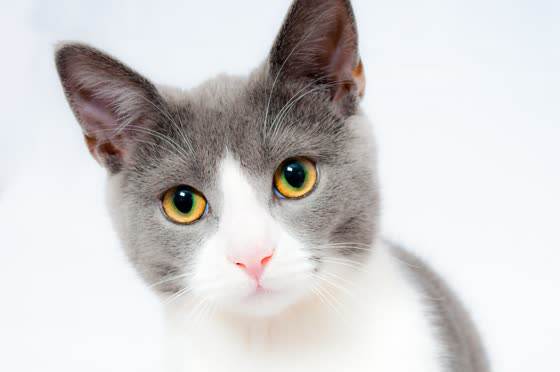

In [14]:
img_pil

In [15]:
img_tensor = preprocess(img_pil)

In [16]:
to_pil = torchvision.transforms.ToPILImage()
i = to_pil(img_tensor)

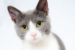

In [17]:
i

In [18]:
to_pil(img_tensor[:,10:30,5:25])

In [19]:
img_tensor.shape

torch.Size([3, 50, 75])